In [74]:
# Necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loading and Understanding the Data

In [28]:
file_path = r'C:\Users\hp\Downloads\IMLT PROJECT\Breast Cancer.csv'
load_file_path = pd.read_csv(file_path)

In [29]:
breast_cancer = load_file_path
breast_cancer.head(6) #to  understand structure of data and look for missing values and decide if imputation needs to be done.

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4


In [4]:
breast_cancer = breast_cancer.iloc[:, 1:] #removes non-informative column (e.g. sample code number)
breast_cancer.isnull().sum() #looks for missing values

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

'''Imputation is the process of estimating missing values in a dataset. It becomes necessary when there are missing values present in the data. **However, breast cancer data file already contains complete information without any missing values and there is no need for imputation**. The absence of missing data ensures that every data point required for analysis or modeling is already present and can be used directly without any need for estimation or filling in missing values'''

In [5]:
breast_cancer.shape #breast cancer data contains 683 rows and 10 columns 

(683, 10)

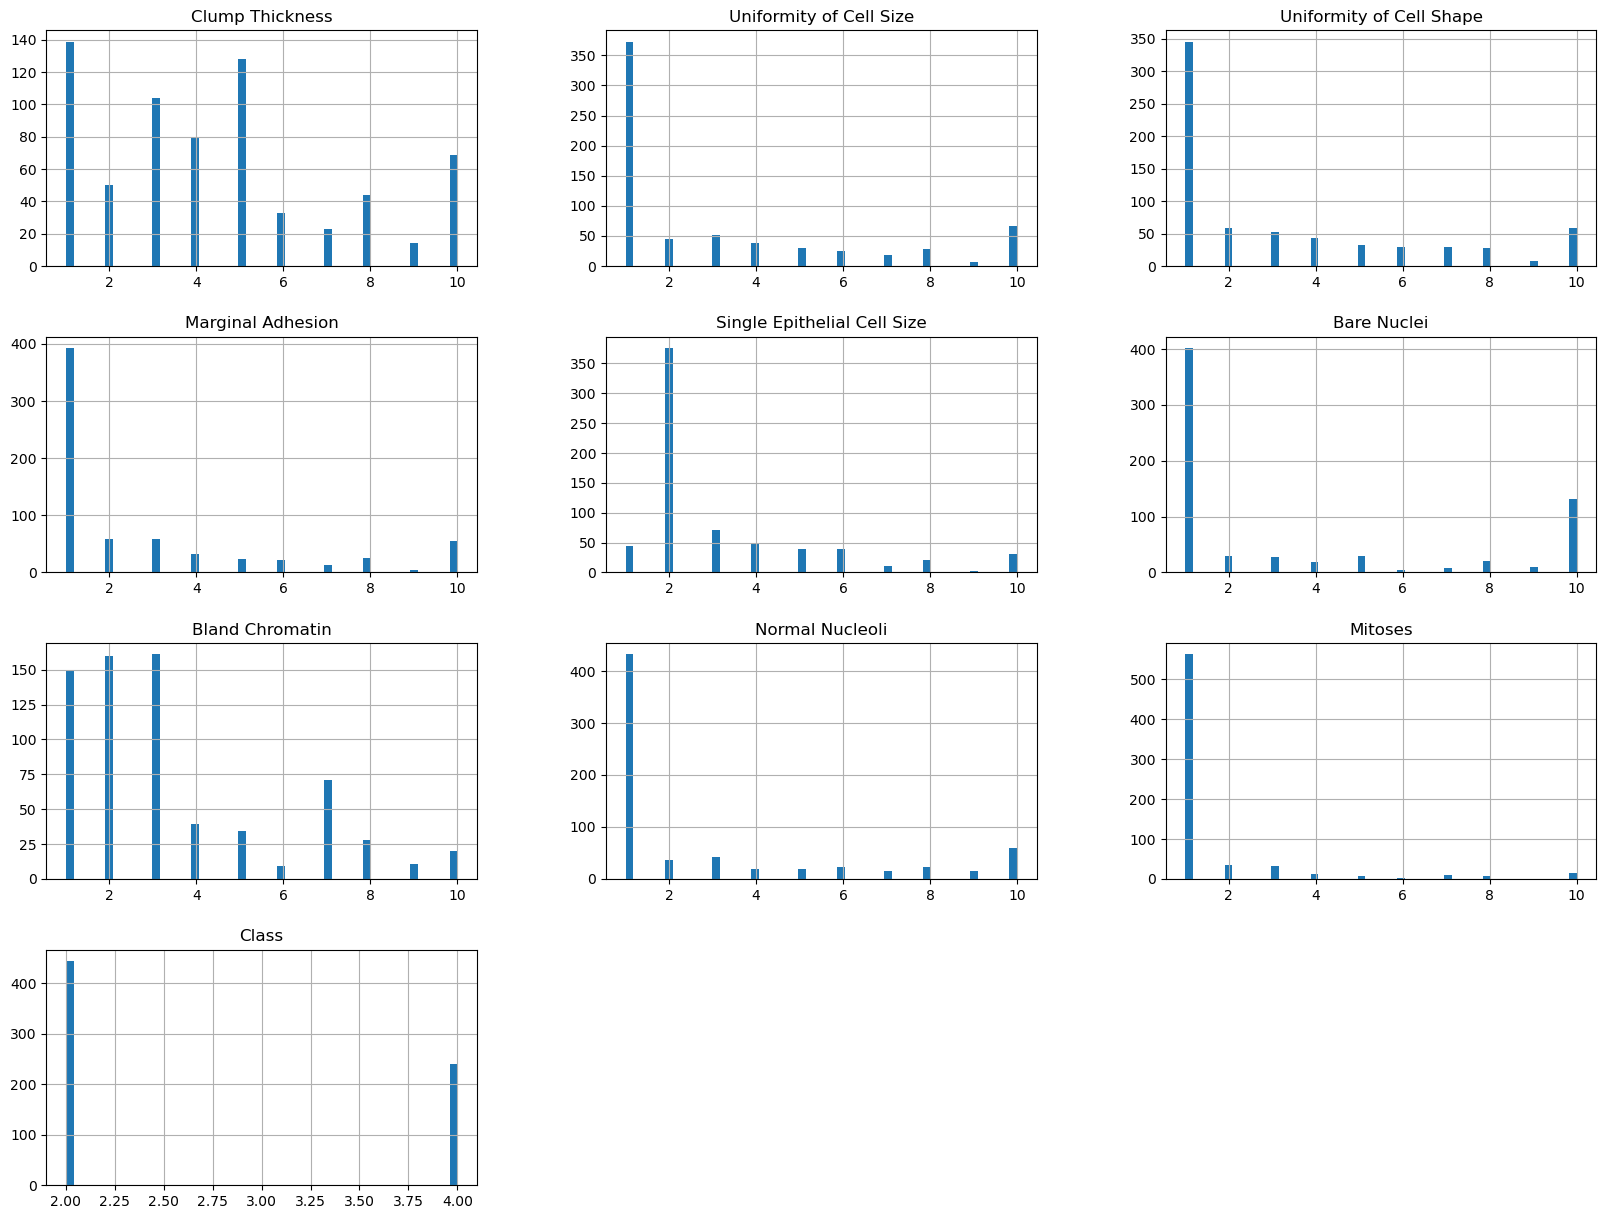

In [6]:
#plotting histogram to understand data

breast_cancer.hist(bins=50, figsize=(20, 15))
plt.show()

Overall, these histograms suggest that malignant cases tend to have higher values and more variability in features related to cell size, shape, and adhesion, as well as chromatin texture and nucleoli size. The histogram for Mitoses shows that both benign and malignant cases have low mitotic activity (mostly around 1-2), indicating that cell division is not a strong distinguishing feature between benign and malignant cases.

# Checking Correlation and Handling Multicollinearity

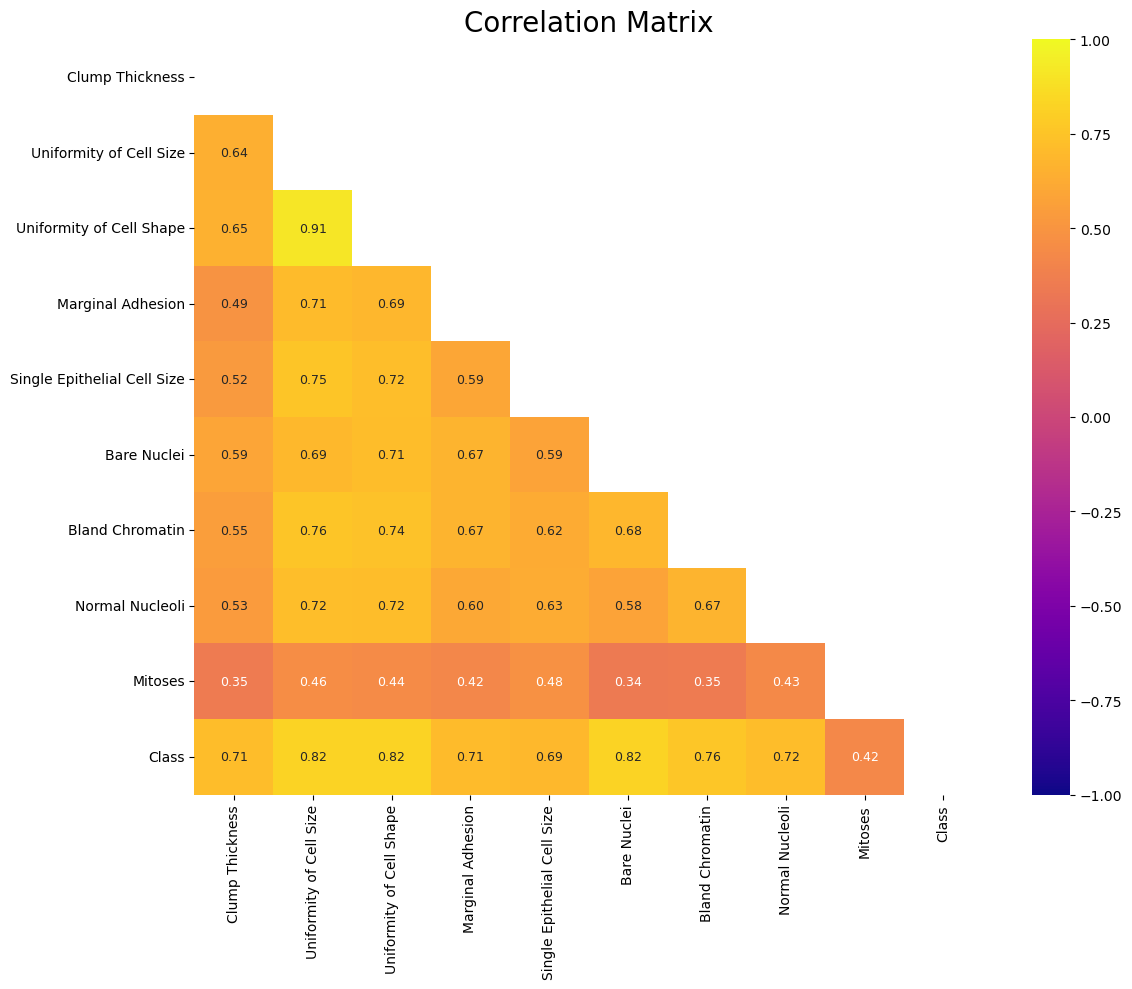

In [7]:
# Calculate the correlation matrix

corr = breast_cancer.corr()

# Mask the upper triangle to avoid redundancy

mask = np.triu(np.ones_like(corr, dtype=bool))

# Matplotlib figure

plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='plasma', cbar=True, annot_kws={"size": 9}, vmin=-1, vmax=1)

# Set title and adjust layout

plt.title('Correlation Matrix', fontsize=20)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot

plt.show()

In [30]:
# Function to extract the correlation value from a pair tuple
def get_correlation(pair):
    """
    Returns the correlation value from a pair tuple.

    Args:
        pair (tuple): A tuple containing two column names and their correlation value.

    Returns:
        float: The correlation value.
    """
    return pair[2]

# Function to identify highly correlated pairs in a correlation matrix
def find_highly_correlated_pairs(corr_matrix, threshold=0.9):
    """
    Finds pairs of columns in a correlation matrix with a correlation value above a specified threshold.

    Args:
        corr_matrix (pandas.DataFrame): A correlation matrix.
        threshold (float, optional): The minimum correlation value to consider. Defaults to 0.9.

    Returns:
        list: A list of tuples, each containing two column names and their correlation value.
    """
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            correlation = abs(corr_matrix.iloc[i, j])
            if correlation >= threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], correlation))

    return high_corr_pairs

In [31]:
# Find highly correlated pairs
threshold = 0.9
high_corr_pairs = find_highly_correlated_pairs(corr, threshold)

# Sort highly correlated pairs by correlation value in descending order
high_corr_pairs.sort(key=get_correlation, reverse=True)

print("Highly correlated pairs (correlation >= 0.9):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation {pair[2]:.2f}")

Highly correlated pairs (correlation >= 0.9):
Uniformity of Cell Size and Uniformity of Cell Shape with correlation 0.91


Here I used correlation-based feature selection with a threshold-based approach, which is a good choice when you have a small to medium-sized dataset and want to reduce feature redundancy. 

In [33]:
# Remove one feature from each highly correlated pair
features_to_remove = []
for pair in high_corr_pairs:
    features_to_remove.append(pair[1])

# Remove duplicates
features_to_remove = list(set(features_to_remove))

print("Features to remove:", features_to_remove)

Features to remove: ['Uniformity of Cell Shape']


In [36]:
# Remove the features from the dataset
breast_cancer_reduced = breast_cancer.drop(columns=features_to_remove)

print("Reduced dataset:", breast_cancer_reduced)

Reduced dataset:      Sample code number  Clump Thickness  Uniformity of Cell Size  \
0               1000025                5                        1   
1               1002945                5                        4   
2               1015425                3                        1   
3               1016277                6                        8   
4               1017023                4                        1   
..                  ...              ...                      ...   
678              776715                3                        1   
679              841769                2                        1   
680              888820                5                       10   
681              897471                4                        8   
682              897471                4                        8   

     Marginal Adhesion  Single Epithelial Cell Size  Bare Nuclei  \
0                    1                            2            1   
1                 

now, I will use the reduced breast cancer data in next steps as it focuses on the most informative features and will provide a clearer understanding of the key factors influencing the model's predictions

# Splitting the Data, Scaling, and Over-sampling

In [37]:
# Splitting the data

X = breast_cancer_reduced.drop('Class', axis=1)  # X contains all features except the 'Class' column
y = breast_cancer_reduced['Class']  # y contains the target variable 'Class'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) ##stratify=y to ensure that the class distribution is preserved in both the training and testing sets.

In [38]:
# Check the distribution of the target variable

class_counts = breast_cancer['Class'].value_counts()
print(class_counts)

Class
2    444
4    239
Name: count, dtype: int64


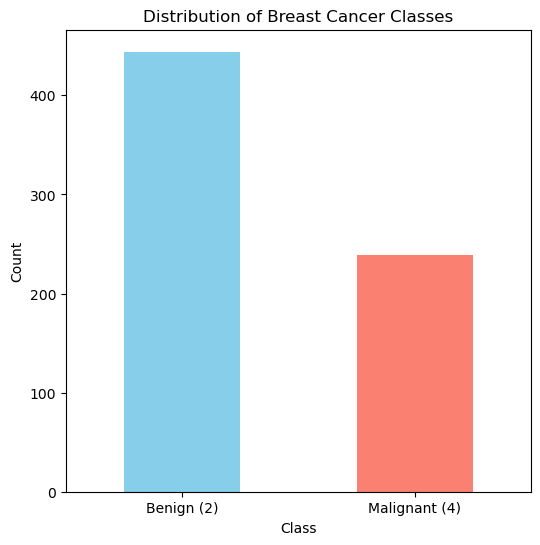

In [39]:
# Plot the class distribution

plt.figure(figsize=(6, 6))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Breast Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Benign (2)', 'Malignant (4)'], rotation=0)
plt.show()

Here I found that the data is imbalanced as we have significantly more benign cases than malignant ones. In such cases, it can be beneficial to apply techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset before training your machine learning models. By doing so, SMOTE will increase the number of malignant class samples, making the dataset more balanced. This can help improve the performance of machine learning models that are sensitive to class imbalance

But before that... I performed standardization. SMOTE is applied after scaling to avoid data leakage and to ensure that synthetic samples are generated based on properly scaled features.

In [40]:
# Standardizing the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling ensures that all features are on the same scale

In [ ]:
#X_train_scaled

In [41]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [42]:
from collections import Counter

# Check class distribution before SMOTE
print("Class distribution before SMOTE:")
print(Counter(y_train))


# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(Counter(y_train_smote))

Class distribution before SMOTE:
Counter({2: 311, 4: 167})
Class distribution after SMOTE:
Counter({2: 311, 4: 311})


The class is now balanced

# Models (without GridSearch)

# K-nearest Neighbors 

For k = 1:
F1 score: 0.92
AUROC score: 0.93

For k = 3:
F1 score: 0.95
AUROC score: 0.97

For k = 5:
F1 score: 0.95
AUROC score: 0.97

For k = 7:
F1 score: 0.95
AUROC score: 0.97

For k = 9:
F1 score: 0.95
AUROC score: 0.97



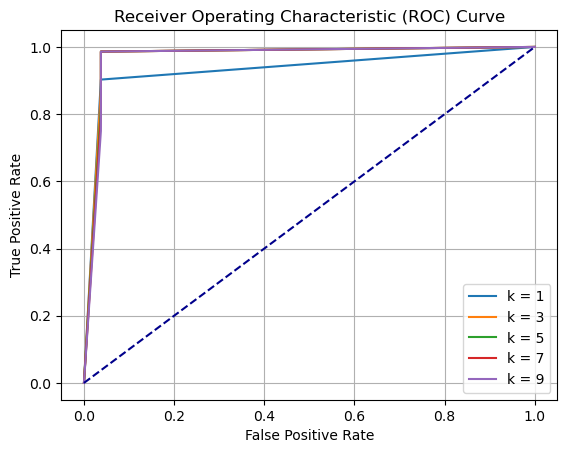

In [43]:
# Values of k
ks = [1, 3, 5, 7, 9]

for k in ks:
    # Create and train the classifier
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train_smote, y_train_smote)
    
    # Predicting with the classifier
    y_pred = classifier.predict(X_test_scaled)
    y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class for AUROC
    
    # Calculate metrics
    F1 = f1_score(y_test, y_pred, pos_label=4)
    auroc = roc_auc_score(y_test, y_pred_proba)
    
    # Print metrics for each k
    print(f'For k = {k}:')
    print(f'F1 score: {F1:.2f}')
    print(f'AUROC score: {auroc:.2f}')
    print()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=4)
    plt.plot(fpr, tpr, label=f'k = {k}')

# Plotting settings
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

According to the F1 score and the ROC curve, we can see that K value of 3, 5,7,9 shows higher true positive rate (TPR) compared to other values, with lowest TPR by k value of 1.

Gridsearch

So what i did next is that: To optimize the K Nearest Neighbors (KNN) model on the breast cancer dataset, I used an iterative approach. Initially, manual testing of K values (1, 3, 5, 7, 9) revealed that K= 3, K= 7, K= 5 and K= 9 showed superior performance in terms of both F1 score and ROC score. 

Subsequently, I employed GridSearchCV to systematically validate these K values. I have done it separately at the end for all models just to compare my own results. 

The process confirmed that K= 7 yielded the best results, achieving optimal performance metrics after cross-validation. This approach ensured the KNN model was finely tuned for predicting breast cancer outcomes, balancing computational efficiency with rigorous validation

# Logistic Regression

I started with a basic Logistic regression model as I already reduced the dataset by removing highly correlated features. Given that multicollinearity should no longer be a significant issue. It provides a clear baseline for model performance and interpretation before exploring more advanced techniques.

For Binary Classification: Since the task involves predicting between two classes (benign and malignant), logistic regression is generally the appropriate choice.

In [46]:
# Building and fitting the Logistic Regression model with L1 regularization
logistic_model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')  # adjust the C parameter to control the strength of regularization
logistic_model.fit(X_train_smote, y_train_smote)

# Predicting with the Logistic Regression model
y_pred = logistic_model.predict(X_test_scaled)
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1 (malignant)

# Evaluating the Logistic Regression model
print("Logistic Regression Performance Metrics:")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=4)  # Use pos_label=4 for AUROC calculation
roc_auc = auc(fpr, tpr)
print(f"\nAUROC: {roc_auc:.2f}")

Logistic Regression Performance Metrics:

Classification Report:
               precision    recall  f1-score   support

           2       0.97      0.96      0.97       133
           4       0.93      0.94      0.94        72

    accuracy                           0.96       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.96      0.96      0.96       205


AUROC: 0.99


Here i got a macro average of 0.95 for F1 score and 0.99 for the AUROC value

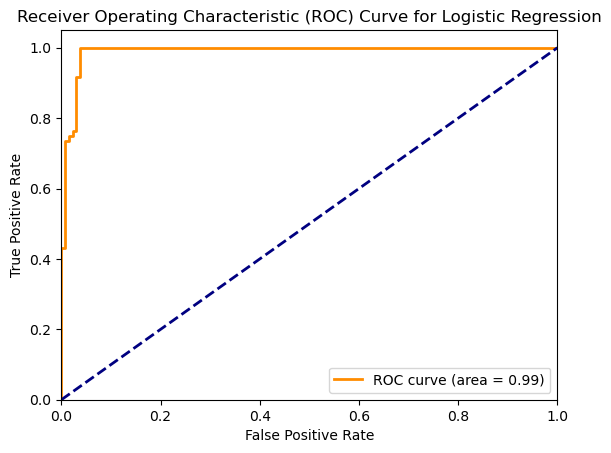

In [47]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

just to explore further...  i dont necessarily have to include it but just wanted to see the results. 

In [48]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_smote, y_train_smote)
y_pred_ridge = ridge_model.predict(X_test_scaled)

print("\nRidge Regression Performance Metrics:")
print("R-squared:", r2_score(y_test, y_pred_ridge))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_ridge))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_ridge))


Ridge Regression Performance Metrics:
R-squared: 0.8061765436547592
Mean Squared Error (MSE): 0.17666183633190016
Mean Absolute Error (MAE): 0.28032014008970774


In [49]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_smote, y_train_smote)
y_pred_lasso = lasso_model.predict(X_test_scaled)

print("\nLasso Regression Performance Metrics:")
print("R-squared:", r2_score(y_test, y_pred_lasso))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_lasso))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_lasso))


Lasso Regression Performance Metrics:
R-squared: 0.7797140100241022
Mean Squared Error (MSE): 0.20078131017339168
Mean Absolute Error (MAE): 0.33168407879461553


Ridge Regression: 

*
Useful when you want to add a penalty to the coefficients to prevent overfitting, especially useful if even after removing highly correlated features, you suspect some remaining multicollinearity.

Lasso Regression: 

*
Useful for feature selection since it can shrink some coefficients to zero. This helps in identifying the most significant features.

**Logistic Regression vs. Ridge/Lasso Regression**:
 - **Accuracy**: The simple logistic regression model has an accuracy of 96%, which is slightly higher compared to evaluating based on R-squared for regression models. Accuracy directly measures the correct predictions over all predictions made, while R-squared in regression measures the proportion of the variance in the dependent variable that is predictable from the independent variables. So it wasnt really needed but i just wanted to experiment.  

# Decision Tree

In [50]:

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
dt_classifier.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = dt_classifier.predict(X_test_scaled)
y_pred_proba = dt_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculate F1 score
f1 = f1_score(y_test, y_pred, pos_label=4)
print(f'F1 score: {f1:.2f}')

# Calculate AUROC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=4)
auroc = auc(fpr, tpr)
print(f'AUROC score: {auroc:.2f}')


F1 score: 0.89
AUROC score: 0.91


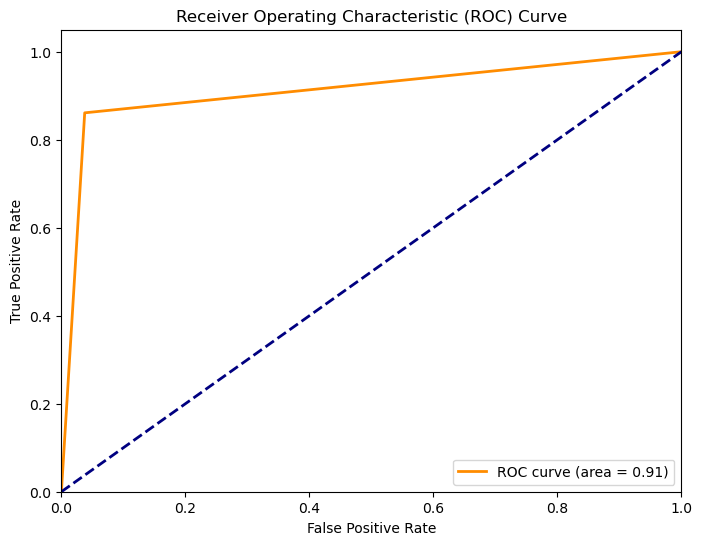

In [51]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Random Forest

Now, I know that Decision trees can cause overfitting, so to avoid that we can use Random forest or Adaboost models. I will first look at Random forest

In [52]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculate F1 score
f1 = f1_score(y_test, y_pred, pos_label=4)
print(f'F1 score: {f1:.2f}')

# Calculate AUROC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=4)
auroc = auc(fpr, tpr)
print(f'AUROC score: {auroc:.2f}')

F1 score: 0.95
AUROC score: 0.99


it has better scores than the decision tree model (without tuning its hyperparameters)

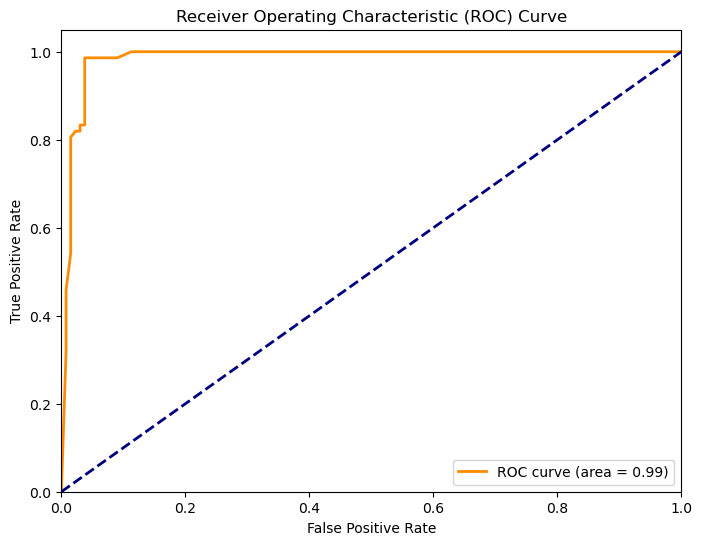

In [53]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# AdaBoost

In [54]:
import warnings

# Ignore warning: added this because it was showing me some warning
warnings.filterwarnings('ignore')

In [55]:
# Initialize the AdaBoost classifier with a base estimator (Decision Tree is default)
adaboost_classifier = AdaBoostClassifier(random_state=42)

# Train the classifier
adaboost_classifier.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = adaboost_classifier.predict(X_test_scaled)
y_pred_proba = adaboost_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculate F1 score
f1 = f1_score(y_test, y_pred, pos_label=4)
print(f'F1 score: {f1:.2f}')

# Calculate AUROC score
auroc = roc_auc_score(y_test, y_pred_proba)
print(f'AUROC score: {auroc:.2f}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=4)

# Calculate Area Under the ROC Curve (AUROC)
roc_auc = auc(fpr, tpr)

F1 score: 0.94
AUROC score: 0.98


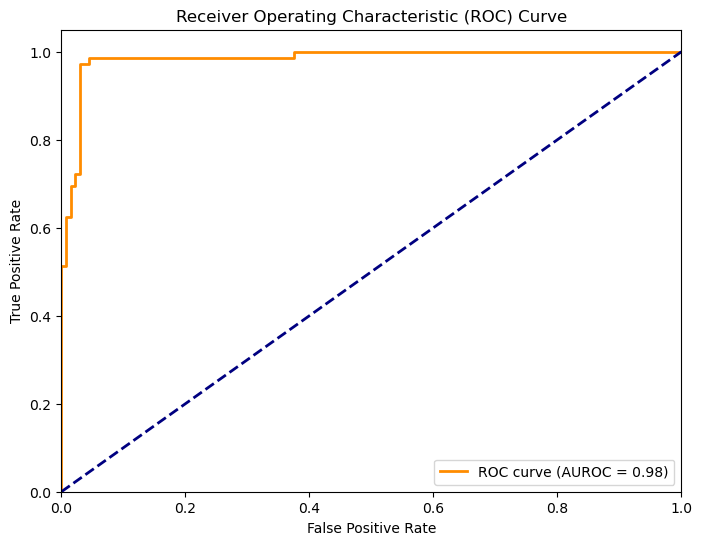

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting

In [57]:
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the classifier
gb_classifier.fit(X_train_smote, y_train_smote)

# Predict probabilities for the positive class (class 4)
y_pred_proba = gb_classifier.predict_proba(X_test_scaled)[:, 1]

# Predict class labels
y_pred = gb_classifier.predict(X_test_scaled)

# Calculate F1 score for class 4 (assuming it's the positive class)
f1 = f1_score(y_test, y_pred, pos_label=4)
print(f'F1 score: {f1:.2f}')

# Calculate AUROC score
auroc = roc_auc_score(y_test, y_pred_proba)
print(f'AUROC score: {auroc:.2f}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=4)
roc_auc = auc(fpr, tpr)

F1 score: 0.93
AUROC score: 0.99


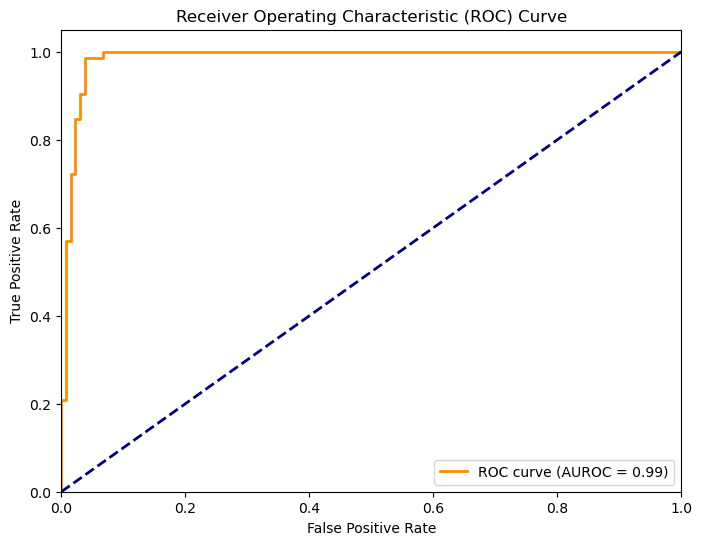

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# SVM

In [59]:
# Initialize the SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Train the classifier
svm_classifier.fit(X_train_smote, y_train_smote)

# Predict probabilities for the positive class (malignant)
y_pred_proba = svm_classifier.predict_proba(X_test_scaled)[:, 1]

# Predict class labels
y_pred = svm_classifier.predict(X_test_scaled)

# Calculate F1 score for class 4 (assuming it's the positive class)
f1 = f1_score(y_test, y_pred, pos_label=4)
print(f'F1 score: {f1:.2f}')

# Calculate AUROC score
auroc = roc_auc_score(y_test, y_pred_proba)
print(f'AUROC score: {auroc:.2f}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=4)
roc_auc = auc(fpr, tpr)

F1 score: 0.94
AUROC score: 0.97


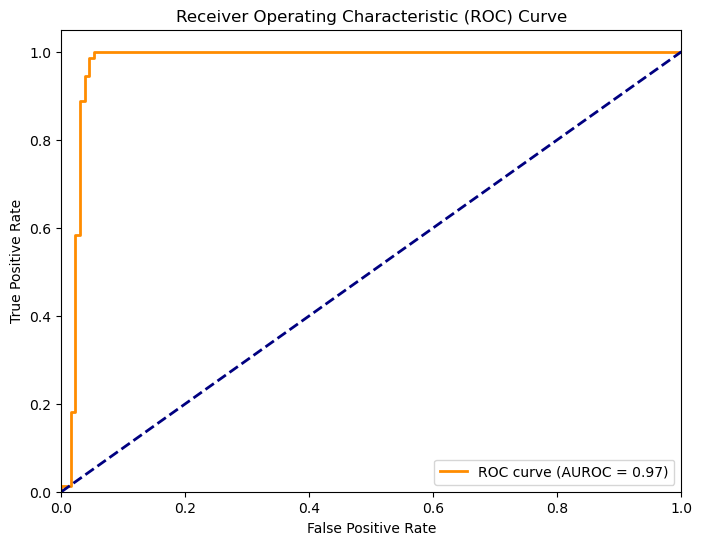

In [60]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Applying gridsearch to all models

In [61]:
# Dictionary to store scores
model_scores = {}

In [62]:
# KNN
param_grid_knn = {
    'n_neighbors': [5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1_macro')
grid_search_knn.fit(X_train_smote, y_train_smote)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_proba_knn = best_knn.predict_proba(X_test_scaled)[:, 1]
knn_f1 = f1_score(y_test, y_pred_knn, pos_label=4)
knn_auroc = roc_auc_score(y_test, y_pred_proba_knn)
model_scores['KNN'] = {'F1 score': knn_f1, 'AUROC score': knn_auroc}

In [63]:
# Logistic Regression
param_grid_lr = [
    {'penalty': ['l2'], 'solver': ['lbfgs'], 'C': [1, 5, 10], 'max_iter': [500, 1000, 2000]},
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [1, 5, 10], 'max_iter': [500, 1000, 2000]}
]
lr = LogisticRegression()
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1_macro')
grid_search_lr.fit(X_train_smote, y_train_smote)
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)[:, 1]
lr_f1 = f1_score(y_test, y_pred_lr, pos_label=4)
lr_auroc = roc_auc_score(y_test, y_pred_proba_lr)
model_scores['Logistic Regression'] = {'F1 score': lr_f1, 'AUROC score': lr_auroc}

In [64]:
# Decision Tree
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1_macro')
grid_search_dt.fit(X_train_smote, y_train_smote)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
y_pred_proba_dt = best_dt.predict_proba(X_test_scaled)[:, 1]
dt_f1 = f1_score(y_test, y_pred_dt, pos_label=4)
dt_auroc = roc_auc_score(y_test, y_pred_proba_dt)
model_scores['Decision Tree'] = {'F1 score': dt_f1, 'AUROC score': dt_auroc}

In [65]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_rf.fit(X_train_smote, y_train_smote)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
rf_f1 = f1_score(y_test, y_pred_rf, pos_label=4)
rf_auroc = roc_auc_score(y_test, y_pred_proba_rf)
model_scores['Random Forest'] = {'F1 score': rf_f1, 'AUROC score': rf_auroc}

In [66]:
# AdaBoost
param_grid_ab = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.1, 0.5, 1, 2, 5],
    'algorithm': ['SAMME']  # Use 'SAMME' to avoid deprecation warning
}
ab = AdaBoostClassifier(random_state=42)
grid_search_ab = GridSearchCV(ab, param_grid_ab, cv=5, scoring='f1_macro')
grid_search_ab.fit(X_train_smote, y_train_smote)
best_ab = grid_search_ab.best_estimator_
y_pred_ab = best_ab.predict(X_test_scaled)
y_pred_proba_ab = best_ab.predict_proba(X_test_scaled)[:, 1]
ab_f1 = f1_score(y_test, y_pred_ab, pos_label=4)
ab_auroc = roc_auc_score(y_test, y_pred_proba_ab)
model_scores['AdaBoost'] = {'F1 score': ab_f1, 'AUROC score': ab_auroc}

In [67]:
# Gradient Boosting
param_grid_gb = {
    'n_estimators': [200, 300],
    'learning_rate': [0.1, 0.5],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'subsample': [0.8]
}
gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='f1_macro')
grid_search_gb.fit(X_train_smote, y_train_smote)
best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_scaled)
y_pred_proba_gb = best_gb.predict_proba(X_test_scaled)[:, 1]
gb_f1 = f1_score(y_test, y_pred_gb, pos_label=4)
gb_auroc = roc_auc_score(y_test, y_pred_proba_gb)
model_scores['Gradient Boosting'] = {'F1 score': gb_f1, 'AUROC score': gb_auroc}

In [68]:
# SVM
param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4, 5]
}
svm = SVC(probability=True, random_state=42)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1_macro')
grid_search_svm.fit(X_train_smote, y_train_smote)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
y_pred_proba_svm = best_svm.predict_proba(X_test_scaled)[:, 1]
svm_f1 = f1_score(y_test, y_pred_svm, pos_label=4)
svm_auroc = roc_auc_score(y_test, y_pred_proba_svm)
model_scores['SVM'] = {'F1 score': svm_f1, 'AUROC score': svm_auroc}

In [69]:
# Print results stored in the dictionary
for model, scores in model_scores.items():
    print(f'{model} - F1 score: {scores["F1 score"]:.2f}, AUROC score: {scores["AUROC score"]:.2f}')

KNN - F1 score: 0.95, AUROC score: 0.97
Logistic Regression - F1 score: 0.95, AUROC score: 0.99
Decision Tree - F1 score: 0.91, AUROC score: 0.94
Random Forest - F1 score: 0.95, AUROC score: 0.99
AdaBoost - F1 score: 0.94, AUROC score: 0.98
Gradient Boosting - F1 score: 0.95, AUROC score: 0.99
SVM - F1 score: 0.95, AUROC score: 0.99


In [71]:
print("Best Parameters found: ")

print("\nKNN: ", grid_search_knn.best_params_)
print("\nLogistic Regression: ", grid_search_lr.best_params_)
print("\nDesician Tree: ", grid_search_dt.best_params_)
print("\nRandom Forest: ", grid_search_rf.best_params_)
print("\nAdaboost: ", grid_search_ab.best_params_)
print("\nGradient Boosting-: ", grid_search_gb.best_params_)
print("\nSVM-: ", grid_search_svm.best_params_)

Best Parameters found: 

KNN:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Logistic Regression:  {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}

Desician Tree:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Random Forest:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}

Adaboost:  {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 300}

Gradient Boosting-:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}

SVM-:  {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


# F1 and AUROC Plots for Models

In [75]:
# Function to plot ROC and F1 curve for a given model
def plot_model_performance(model_name, y_test, y_pred_proba, y_pred, pos_label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=pos_label)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    # Plot ROC curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    
    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve - {model_name}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

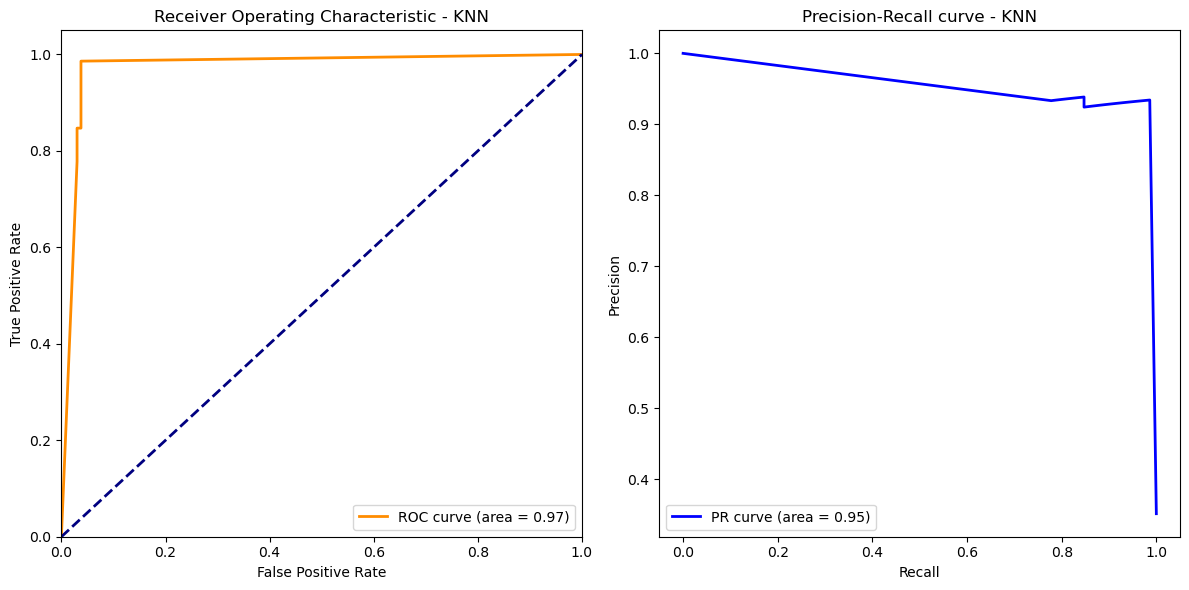

In [76]:
# KNN
plot_model_performance('KNN', y_test, y_pred_proba_knn, y_pred_knn, pos_label=4)

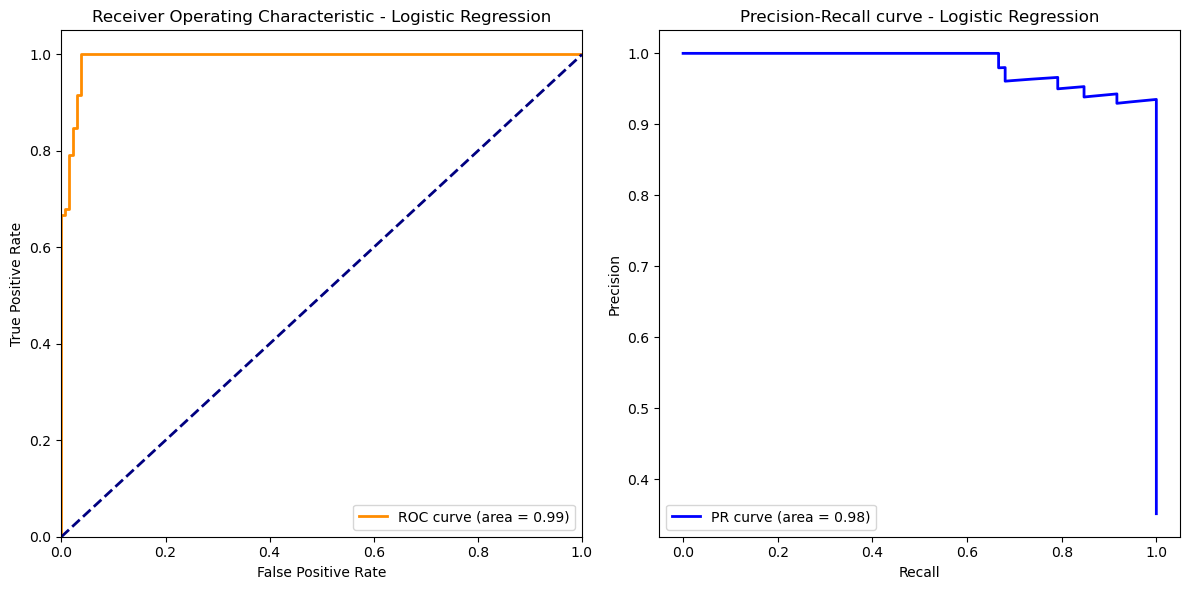

In [77]:
# Logistic Regression
plot_model_performance('Logistic Regression', y_test, y_pred_proba_lr, y_pred_lr, pos_label=4)

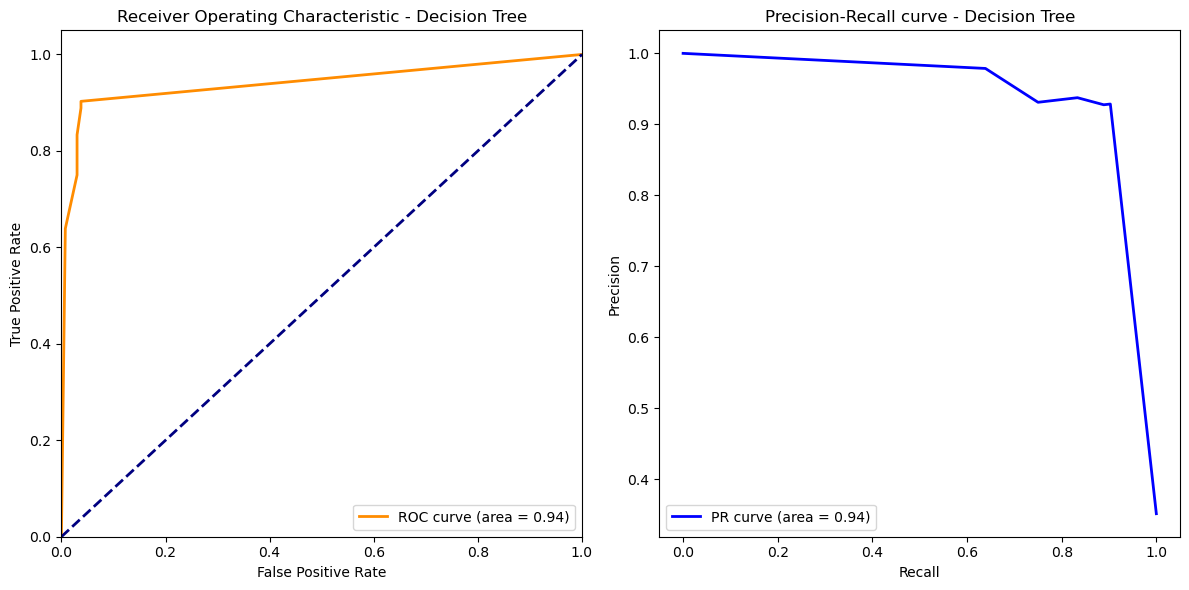

In [78]:
# Decision Tree
plot_model_performance('Decision Tree', y_test, y_pred_proba_dt, y_pred_dt, pos_label=4)

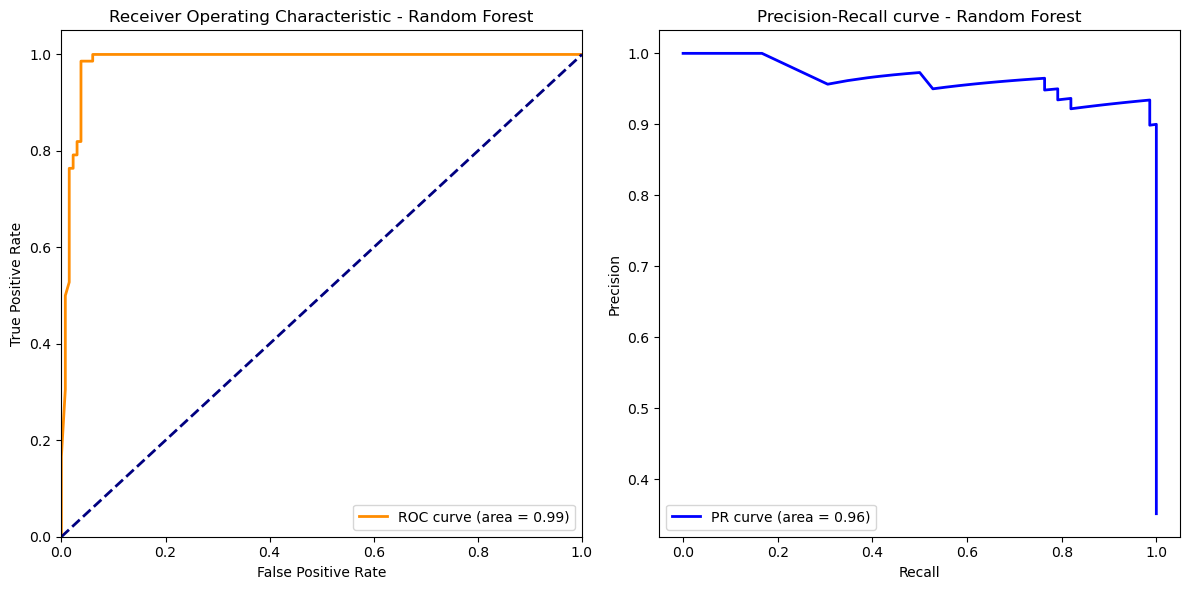

In [79]:
# Random Forest
plot_model_performance('Random Forest', y_test, y_pred_proba_rf, y_pred_rf, pos_label=4)

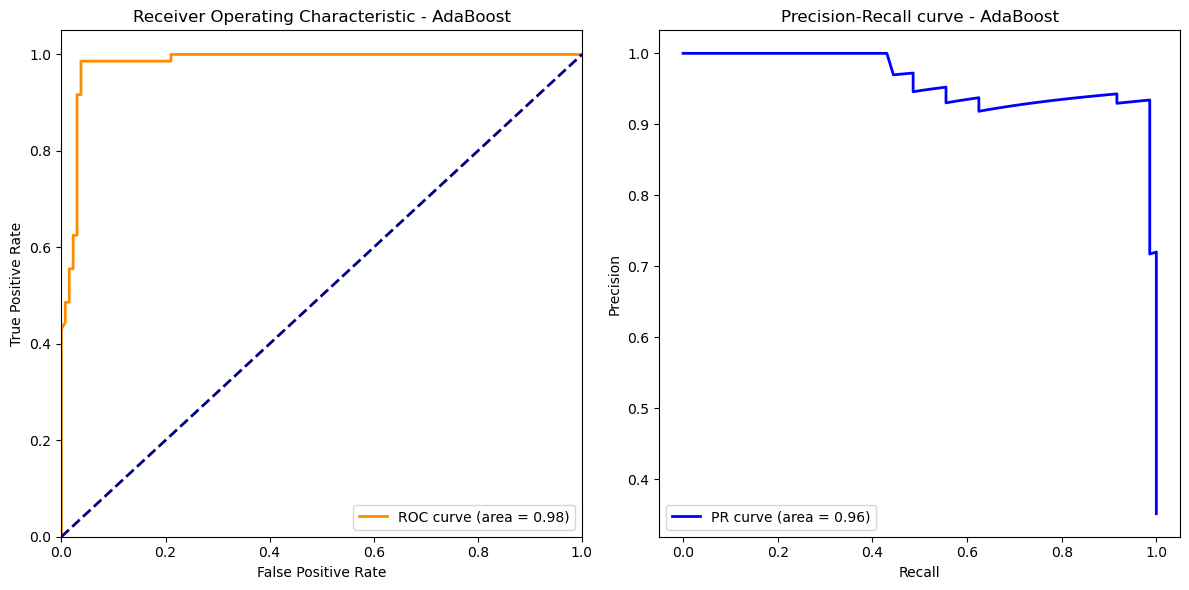

In [80]:
# AdaBoost
plot_model_performance('AdaBoost', y_test, y_pred_proba_ab, y_pred_ab, pos_label=4)

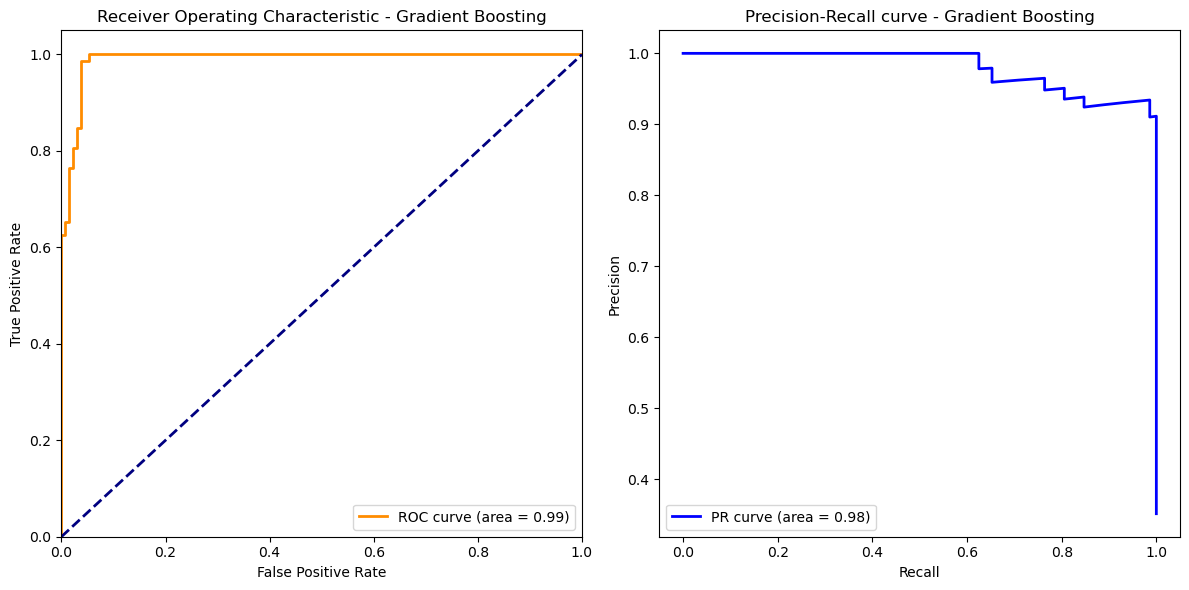

In [81]:
# Gradient Boosting
plot_model_performance('Gradient Boosting', y_test, y_pred_proba_gb, y_pred_gb, pos_label=4)

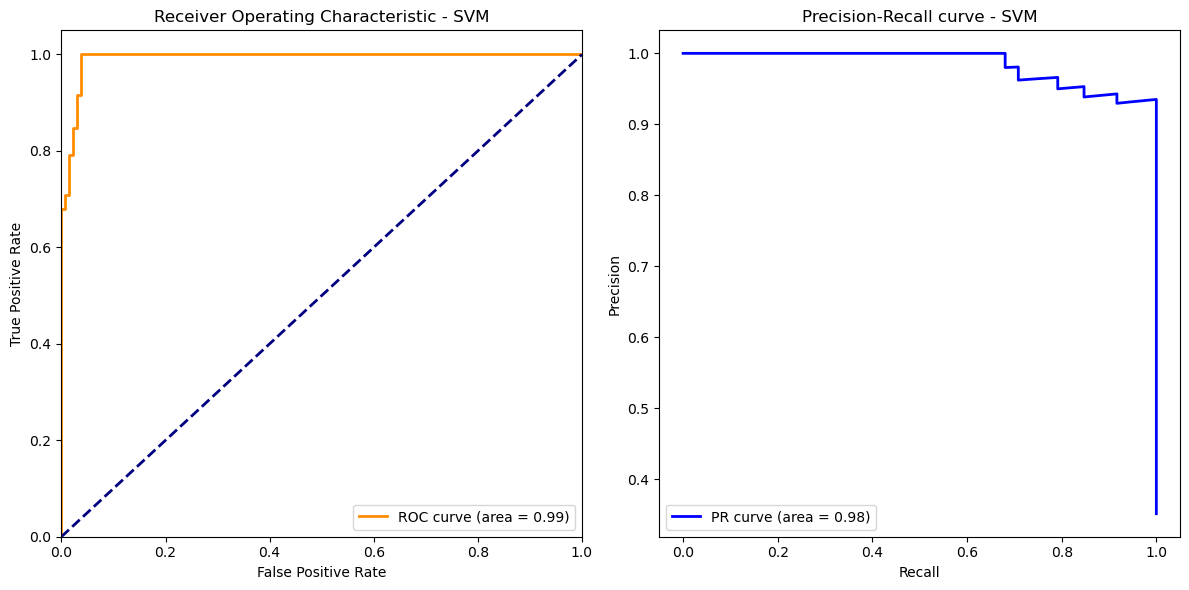

In [82]:
# SVM
plot_model_performance('SVM', y_test, y_pred_proba_svm, y_pred_svm, pos_label=4)

To Compare more precisely..

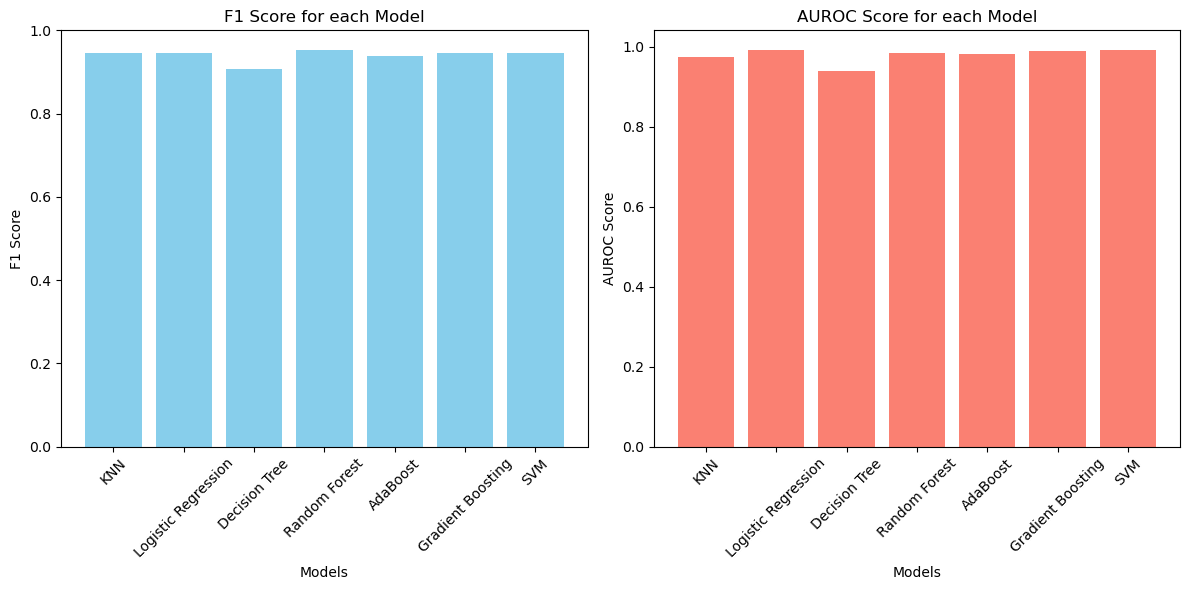

In [83]:
# Extract model names, F1 scores, and AUROC scores
models = list(model_scores.keys())
f1_scores = [model_scores[model]['F1 score'] for model in models]
auroc_scores = [model_scores[model]['AUROC score'] for model in models]

# Plot F1 scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models, f1_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score for each Model')
plt.xticks(rotation=45)

# Plot AUROC scores
plt.subplot(1, 2, 2)
plt.bar(models, auroc_scores, color='salmon')
plt.xlabel('Models')
plt.ylabel('AUROC Score')
plt.title('AUROC Score for each Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**According to the results, GridSearchCV helped to improve the performance of some models, but not all.**

KNN: Scores remain the same. The default parameters might have already been optimal or close to optimal, leading to no significant change after grid search.

Logistic Rgression: same as KNN, no changes are observed in the scores. is less sensitive to hyperparameter tuning compared to other models, especially when the dataset is well-scaled and balanced. 

Decision Tree:  Shows slight improvement in F1 score (from 0.89 to 0.91) and significant improvement in AUROC score (from 0.91 to 0.94). Grid search helps in finding better depth and splitting criteria, reducing overfitting, and improving overall performance.

Random Forest: No change observed. Scores remain the same: default parameters might have been sufficient for good performance

Adaboost: No change in scores. It must be less sensitive to parameter changes given the dataset and initial conditions, maintaining high performance.

Gradient Boosting: Improvement in F1 score (from 0.93 to 0.95) only. benefits from fine-tuning the learning rate and number of estimators, leading to better classification performance.

SVM: Increase in F1 score (from 0.94 to 0.9), improvement in AUROC score (from 0.97 to 0.99). This could be because it is highly sensitive to parameter tuning. 

# Confusion Matrix for all models

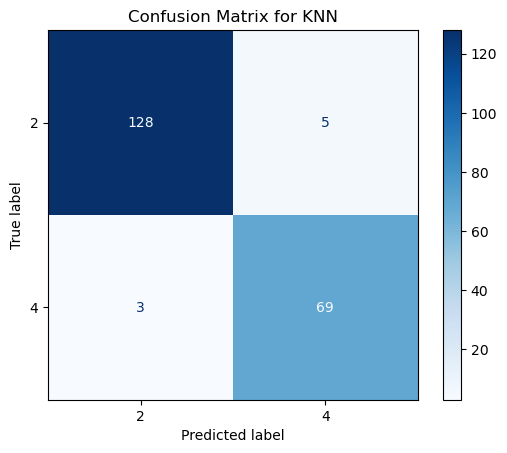

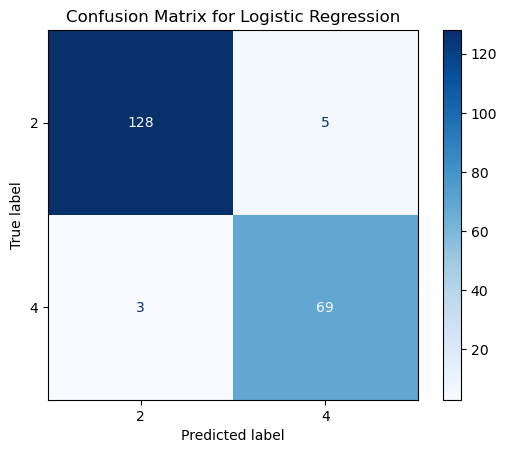

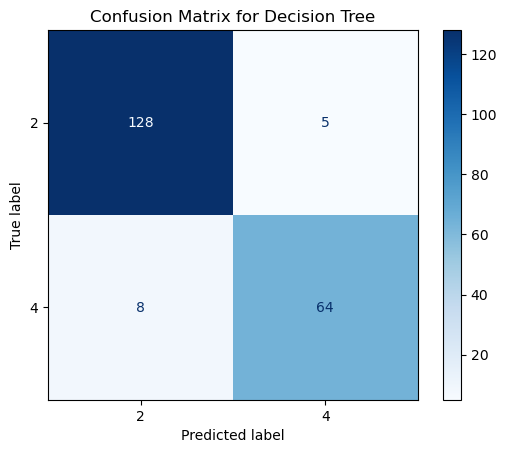

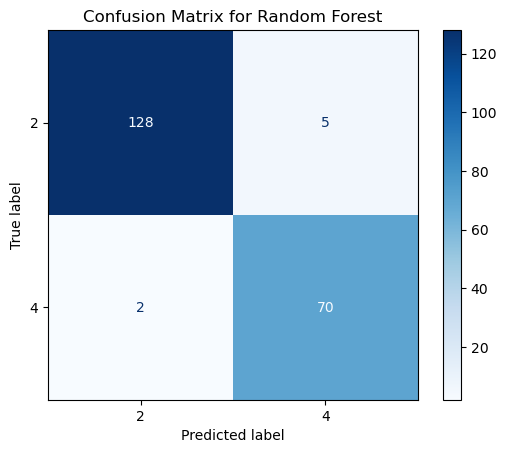

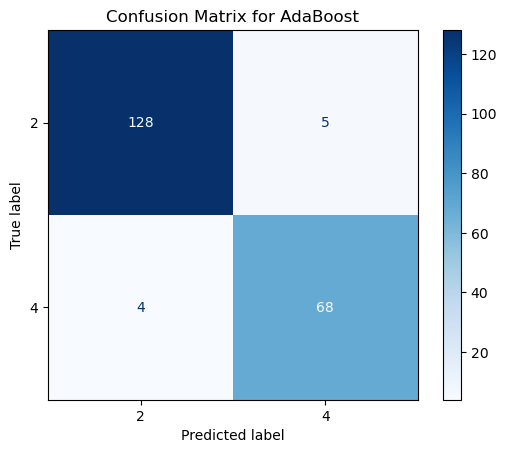

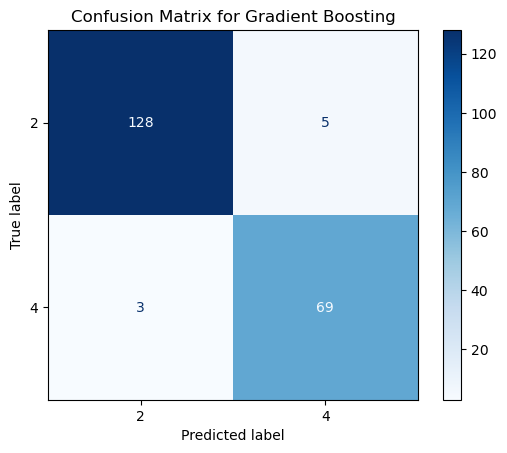

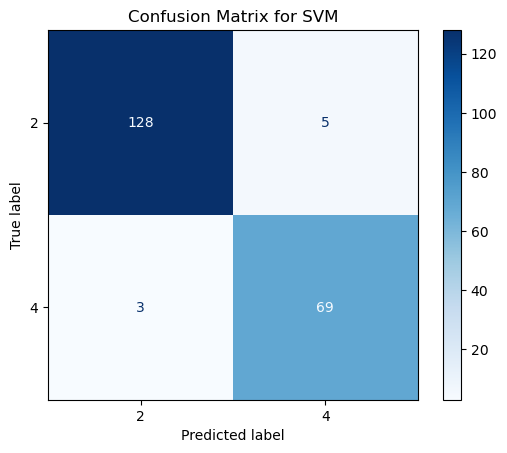

In [84]:
# Initialize a dictionary to store confusion matrix displays
confusion_matrices = {}

# Calculate confusion matrix and display for each model
for model_name, model in {'KNN': best_knn, 'Logistic Regression': best_lr, 'Decision Tree': best_dt,
                          'Random Forest': best_rf, 'AdaBoost': best_ab, 'Gradient Boosting': best_gb,
                          'SVM': best_svm}.items():
    # Predict labels using the model
    y_pred = model.predict(X_test_scaled)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.grid(False)
    plt.show()

# Calculating feature importances

In [85]:
# Function to plot feature importances
def plot_feature_importances(model_name, importances, feature_names):
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importances_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Display the sorted feature importances
    print(f"{model_name} Feature Importances:")
    print(importances_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importances_df)
    plt.title(f'{model_name} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Assuming X is the original DataFrame with feature names
feature_names = X.columns

Decision Tree Feature Importances:
                       Feature  Importance
2      Uniformity of Cell Size    0.810487
5                  Bare Nuclei    0.108940
3            Marginal Adhesion    0.028396
1              Clump Thickness    0.026401
7              Normal Nucleoli    0.016150
0           Sample code number    0.005147
4  Single Epithelial Cell Size    0.004479
6              Bland Chromatin    0.000000
8                      Mitoses    0.000000


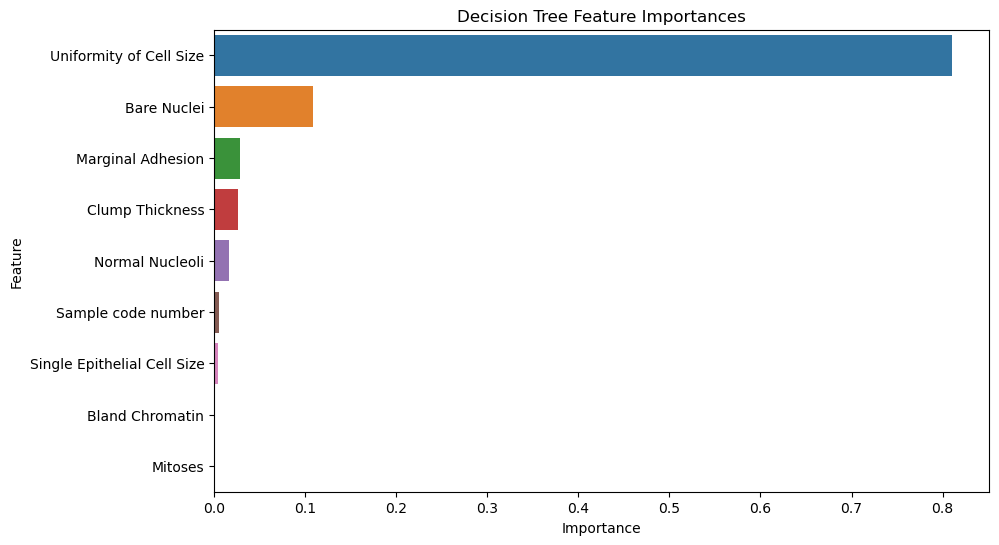

In [87]:
# Decision Tree
dt_importances = best_dt.feature_importances_
plot_feature_importances('Decision Tree', dt_importances, feature_names)

Random Forest Feature Importances:
                       Feature  Importance
2      Uniformity of Cell Size    0.324261
5                  Bare Nuclei    0.228278
4  Single Epithelial Cell Size    0.150556
6              Bland Chromatin    0.114841
7              Normal Nucleoli    0.065912
3            Marginal Adhesion    0.054577
1              Clump Thickness    0.041026
0           Sample code number    0.013654
8                      Mitoses    0.006895


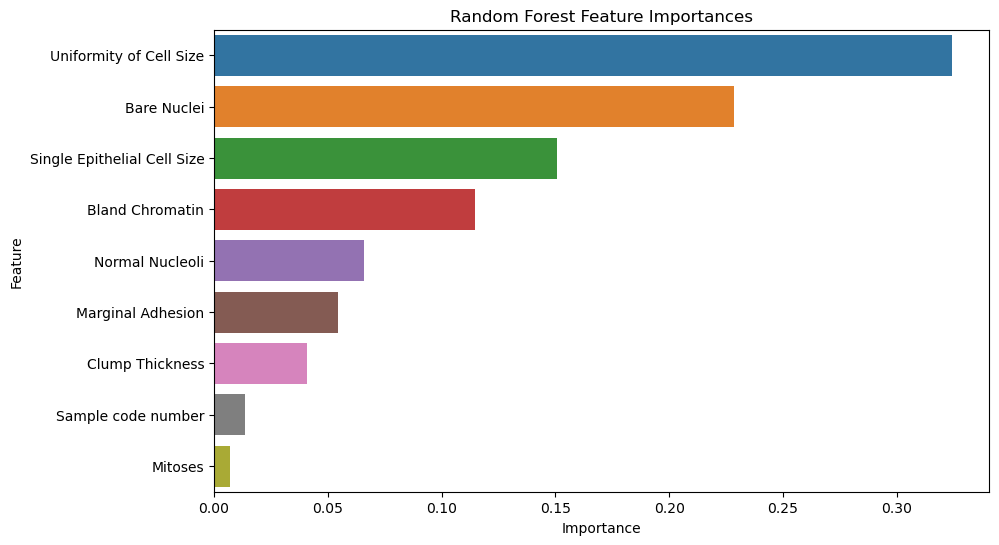

In [86]:
# Random Forest
rf_importances = best_rf.feature_importances_
plot_feature_importances('Random Forest', rf_importances, feature_names)

AdaBoost Feature Importances:
                       Feature  Importance
5                  Bare Nuclei    0.228004
2      Uniformity of Cell Size    0.203089
1              Clump Thickness    0.189933
7              Normal Nucleoli    0.147075
3            Marginal Adhesion    0.079012
8                      Mitoses    0.058049
6              Bland Chromatin    0.048266
4  Single Epithelial Cell Size    0.026757
0           Sample code number    0.019815


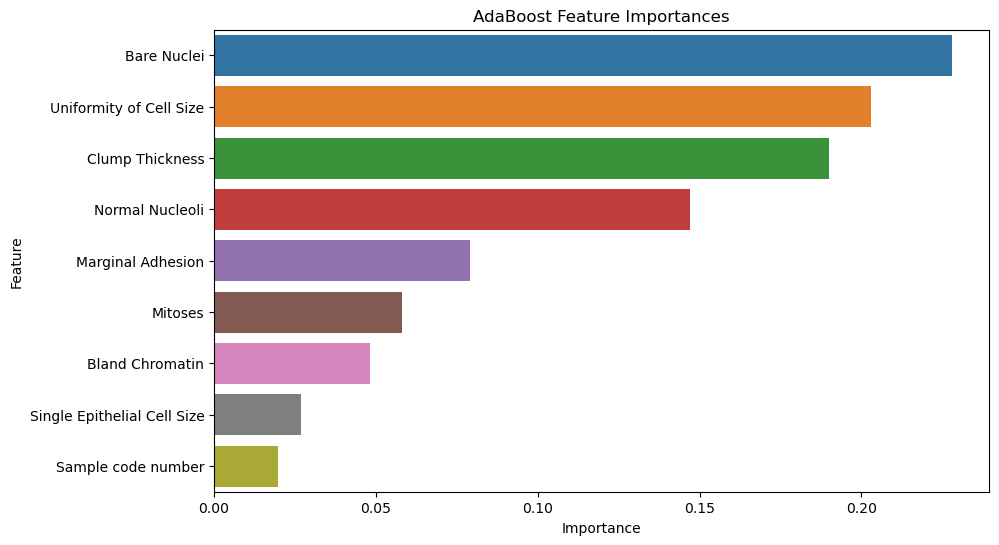

In [88]:
# AdaBoost
ab_importances = best_ab.feature_importances_
plot_feature_importances('AdaBoost', ab_importances, feature_names)s

Gradient Boosting Feature Importances:
                       Feature  Importance
2      Uniformity of Cell Size    0.769617
5                  Bare Nuclei    0.121742
1              Clump Thickness    0.027139
7              Normal Nucleoli    0.026209
3            Marginal Adhesion    0.024011
0           Sample code number    0.018362
4  Single Epithelial Cell Size    0.007336
6              Bland Chromatin    0.004368
8                      Mitoses    0.001215


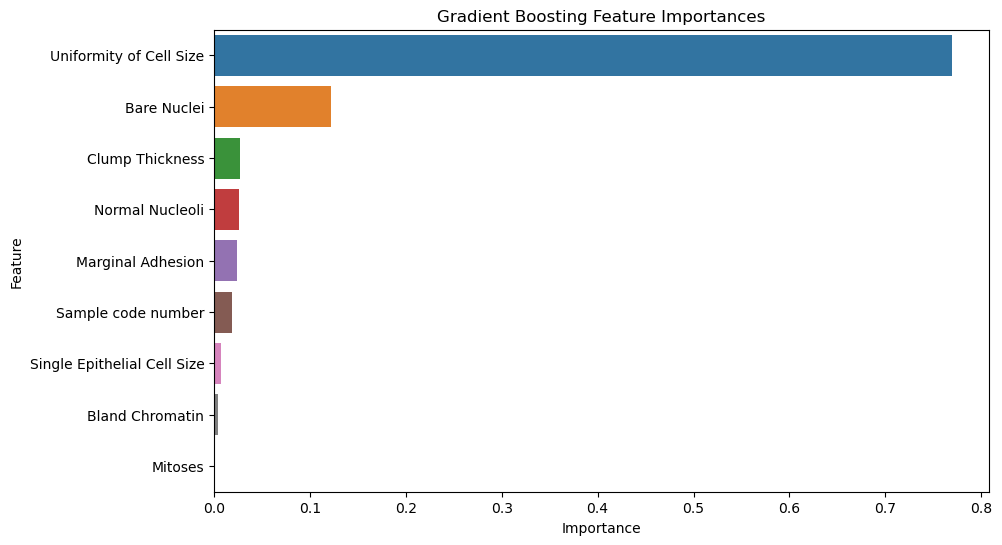

In [89]:
# Gradient Boosting
gb_importances = best_gb.feature_importances_
plot_feature_importances('Gradient Boosting', gb_importances, feature_names)

The feature importance plots for Logistic Regression and SVM will show the coefficients of the model, which may not be directly comparable to feature importance scores obtained from other models like Random Forest or Gradient Boosting as they do not have the inbuilt function to calculate feature importance. Also, since KNN is a distance-based algorithm, it does not provide feature importance scores. We cannot plot feature importances for KNN.

Logistic Regression Feature Importances:
                       Feature  Importance
4                  Bare Nuclei    2.108050
1      Uniformity of Cell Size    1.394081
0              Clump Thickness    1.391832
2            Marginal Adhesion    0.991622
7                      Mitoses    0.887431
6              Normal Nucleoli    0.645977
5              Bland Chromatin    0.475521
3  Single Epithelial Cell Size    0.286769


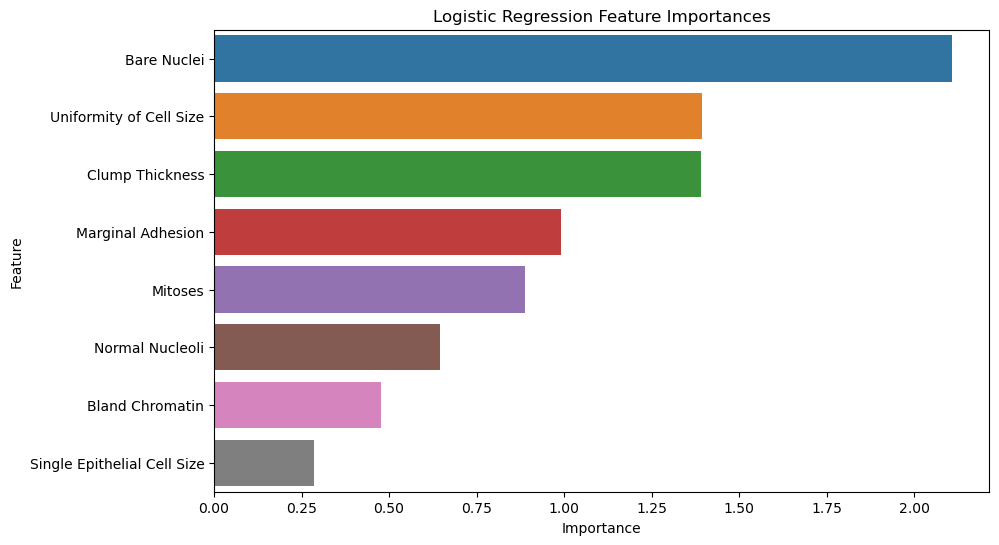

In [98]:
lr_importances = best_lr.coef_[0][1:]  # exclude the first feature (Sample code number)
feature_names = X.columns[1:]  # exclude the first feature (Sample code number)

plot_feature_importances('Logistic Regression', lr_importances, feature_names)

SVM Feature Importances:
                       Feature  Importance
4                  Bare Nuclei    0.800984
0              Clump Thickness    0.524032
1      Uniformity of Cell Size    0.512427
2            Marginal Adhesion    0.389579
6              Normal Nucleoli    0.308440
7                      Mitoses    0.285941
3  Single Epithelial Cell Size    0.195812
5              Bland Chromatin    0.182291


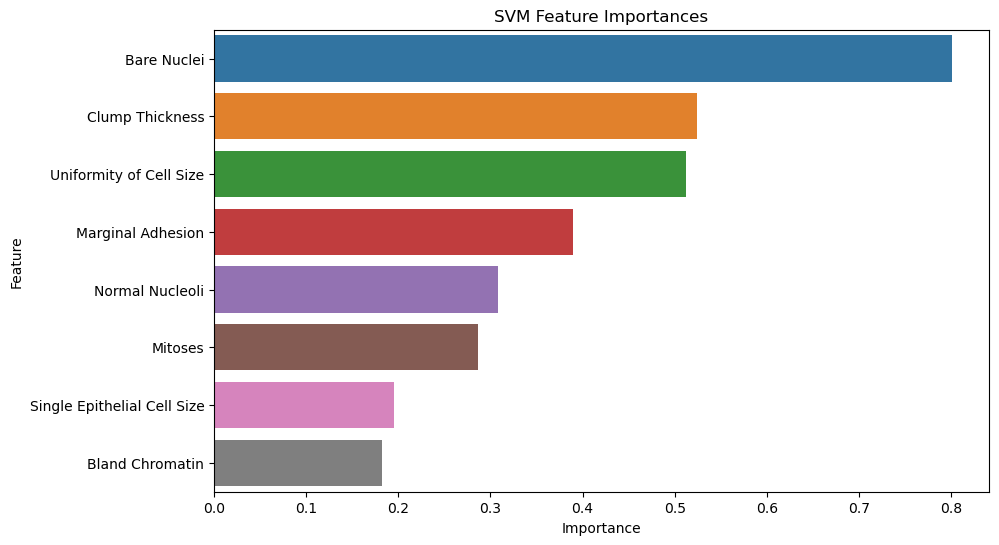

In [99]:
svm_importances = best_svm.coef_[0][1:] 
feature_names = X.columns[1:]  

plot_feature_importances('SVM', svm_importances, feature_names)

Here we can also find Clump thickness in the first two features incluing bare nuclei and uniformity of cell size. 

# Observations:

Two features, **Uniformity of Cell Size and Bare Nuclei**, emerge as consistently important predictors across most models. This suggests that these features play a crucial role in distinguishing between different types of breast cancer.

**Top 3 Feature Importance Comparison**

*Uniformity of Cell Size*

Decision Tree: 0.810487 (highest importance)

Gradient Boosting: 0.769617 (highest importance)

Random Forest: 0.324261 (second-highest importance)

*Bare Nuclei*

AdaBoost: 0.228004 (highest importance)

Random Forest: 0.228278 (second-highest importance)

Decision Tree: 0.108940 (second-highest importance)

*Clump Thickness*

Logistic Regression: 1.391832 (second-highest importance)

SVM: 0.524032 (second-highest importance)

Gradient Boosting: 0.027139 (third-highest importance)

These comparisons highlight the significance of Uniformity of Cell Size, Bare Nuclei, and Clump Thickness in predicting breast cancer outcomes.

The importance ranking and relative contributions of each feature vary significantly between models, highlighting different model behaviors and preferences in feature utilization.

**Mitoses consistently appears as a less important feature across all models**

Also, if we compare Random forests and Gradient boosting (They have the same F1 and Auroc Score: 0.95, 0.99) first top 2 importances, we can see that gradient boosting is heavily relying on Uniformity of Cell Size to make predictions, and Bare Nuclei is playing a secondary role. On the other hand, Random Forest model is more evenly weighting the importance of these two features, recognizing their complementary roles in breast cancer diagnosis. 

# Comparing with Literature 

In histopathology, uniformity of cell size is a critical feature used to assess the degree of abnormality in cell proliferation. Tumors with uniform cell sizes are typically associated with lower grades, indicating slower growth and less aggressive behavior. Higher grades of cancer exhibit greater variability in cell size, reflecting rapid and irregular cell division.

In breast cancer grading, nuclear characteristics such as size, shape, and staining intensity (nuclear pleomorphism) are pivotal. Increased prominence of bare nuclei often correlates with higher grades of breast cancer, where nuclei are larger, irregular, and exhibit abnormal chromatin patterns.

Aziz, S., Munir, K., Raza, A., Almutairi, M. S., & Nawaz, S. (2023). IVNET: Transfer learning based diagnosis of breast cancer grading using histopathological images of infected cells. IEEE Access, 11, 127880–127894. https://doi.org/10.1109/access.2023.3332541

(Aziz et al., 2023) says that Nuclear pleomorphism, which involves nucleus size,shape, and staining variation, is prevalent in malignant cells. High-grade tumors exhibit more significant nuclear abnormalities, indicating a higher level of aggression 

Uniformity of Cell Size: Reflects variation in nucleus size.
Bare Nuclei: May relate to staining variation.

The feature importance of "Uniformity of cell size" and "Bare Nuclei" in my models reflects its role as a crucial histopathological marker in breast cancer diagnosis. It highlights the significance of nuclear characteristics in assessing tumor aggressiveness and prognosis.

The paper also mentions that "The mitotic index of cancerous tissue measures the rate of cell divisions. A higher mitotic count suggests faster cell division and proliferation, indicating a higher grade.". Despite its clinical importance, it was ranked as the least important feature in random forest and gradient boosting, however it was ranked as 6th most important feature by adaboost and SVM, and 5th most important feature by logistic regression, contributing less compared to  Clump Thickness, Bare Nuclei, and Uniformity of Cell Size. 

# Deciding the best Algorithm...

When choosing between Random Forest and Gradient Boosting for a medical model, such as breast cancer grading, Random Forest might be a preferred option despite Gradient Boosting assigning higher importance to "Uniformity of Cell Size". This is because Random Forest offers several advantages over Gradient Boosting. 

Firstly, Random Forest provides direct feature importances, making it easier to understand which features contribute most to predictions, which is crucial in medical applications where transparency is essential for trust and decision-making. In contrast, Gradient Boosting's sequential nature makes it harder to interpret feature importance.

Random Forest is also generally less complex than Gradient Boosting, which makes it faster to train and deploy, and requires fewer computational resources. Additionally, Random Forest is more robust and less prone to overfitting, capturing noise, and sensitive to outliers, making it a better choice for real-world scenarios with noisy or incomplete data.

Furthermore, Random Forest's balanced approach avoids bias towards specific features, leading to fairer predictions across different patient groups, which is critical in healthcare. Finally, Random Forest is more stable across subsets of data, providing consistent performance, whereas Gradient Boosting may exhibit more variability.

Overall, while Gradient Boosting may assign higher importance to "Uniformity of Cell Size", Random Forest's advantages in interpretability, model complexity, robustness, fairness, and stability make it a more suitable choice for medical applications.

**So, the best Algorithm according to my analysis is Random Forest.**